# Dataset overview

In [2]:
# Cell setup (thêm vào đầu notebook nếu chưa có)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

# Đọc dữ liệu
df = pd.read_csv('../data/raw/student-combine.csv')

In [3]:
'''
Basic Information
• How many rows does your dataset have?
• How many columns does your dataset have?
• What does each row represent? (e.g., one customer, one transaction, one day)
• What is the overall size of the dataset?
'''
# 1. Số lượng hàng và cột
rows, cols = df.shape
print(f"Số lượng hàng: {rows}")
print(f"Số lượng cột: {cols}")

# 2. Ý nghĩa mỗi hàng: Mỗi hàng đại diện cho thông tin nhân khẩu học và kết quả học tập của một học sinh trong một môn học (Toán hoặc Bồ Đào Nha).
# 3. Kích thước tổng thể
print(f"Kích thước bộ dữ liệu (tổng số ô): {df.size}")

# Hiển thị 5 dòng đầu để kiểm tra
display(df.head())

Số lượng hàng: 1044
Số lượng cột: 34
Kích thước bộ dữ liệu (tổng số ô): 35496


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6,mat
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6,mat
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10,mat
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15,mat
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10,mat


In [4]:
'''
Data Integrity
• Are there any duplicated rows? If yes, how many?
• Should duplicates be kept or removed? (Justify your decision)
• Are all rows complete, or are some entirely empty?
Vietnam Nation
'''
# 1. Kiểm tra hàng trùng lặp
duplicates = df.duplicated().sum()
print(f"Số lượng hàng bị trùng lặp hoàn toàn: {duplicates}")

# 2. Quyết định xử lý:
if duplicates > 0:
    print("Có hàng trùng lặp. Cần xem xét loại bỏ để tránh bias mô hình.")
    # Code để xem các hàng trùng: df[df.duplicated()]
else:
    print("Dữ liệu sạch, không có hàng trùng lặp hoàn toàn.")

# 3. Kiểm tra hàng rỗng hoàn toàn
empty_rows = df.isnull().all(axis=1).sum()
print(f"Số lượng hàng rỗng hoàn toàn: {empty_rows}")

Số lượng hàng bị trùng lặp hoàn toàn: 0
Dữ liệu sạch, không có hàng trùng lặp hoàn toàn.
Số lượng hàng rỗng hoàn toàn: 0


In [5]:
''' 
Column Inventory
• What is the meaning/definition of each column?
• Which columns are relevant to potential analysis?
• Are there any columns that should be dropped? Why?
'''
# Liệt kê tất cả các cột
print("Danh sách các cột:", df.columns.tolist())

# Phân loại sơ bộ
target_cols = ['G1', 'G2', 'G3'] # Các cột điểm số (kết quả cần dự đoán) 
context_cols = [c for c in df.columns if c not in target_cols]

print(f"\nCác cột mục tiêu (Output): {target_cols}")
print(f"Các cột đặc trưng (Input): {len(context_cols)} cột")

Danh sách các cột: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'subject']

Các cột mục tiêu (Output): ['G1', 'G2', 'G3']
Các cột đặc trưng (Input): 31 cột


In [6]:
''' 
Data Types:
• What is the current data type of each column?
• Are there columns with inappropriate data types?
• Which columns need type conversion?
'''
# Kiểm tra kiểu dữ liệu
print(df.dtypes)

# Kiểm tra xem có cột nào sai kiểu không (Ví dụ: số nhưng lại lưu là object)
# Trong dataset này, hầu hết các cột số (age, traveltime, grades) thường đã được pandas nhận diện đúng là int64.

school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
subject       object
dtype: object


# Numerical Columns Analysis
làm cái này nè

--- BẢNG THỐNG KÊ MÔ TẢ & HÌNH DÁNG PHÂN PHỐI ---


,Mean,Median,Std Dev,Skewness,Distribution Shape
age,16.726054,17.0,1.239975,0.434028,Symmetrical (Normal-like)
studytime,1.970307,2.0,0.834353,0.670982,Right Skewed (Positively)
absences,4.434866,2.0,6.210017,3.741347,Right Skewed (Positively)
G1,11.213602,11.0,2.983394,0.077922,Symmetrical (Normal-like)
G2,11.246169,11.0,3.285071,-0.497357,Symmetrical (Normal-like)
G3,11.341954,11.0,3.864796,-0.985965,Left Skewed (Negatively)


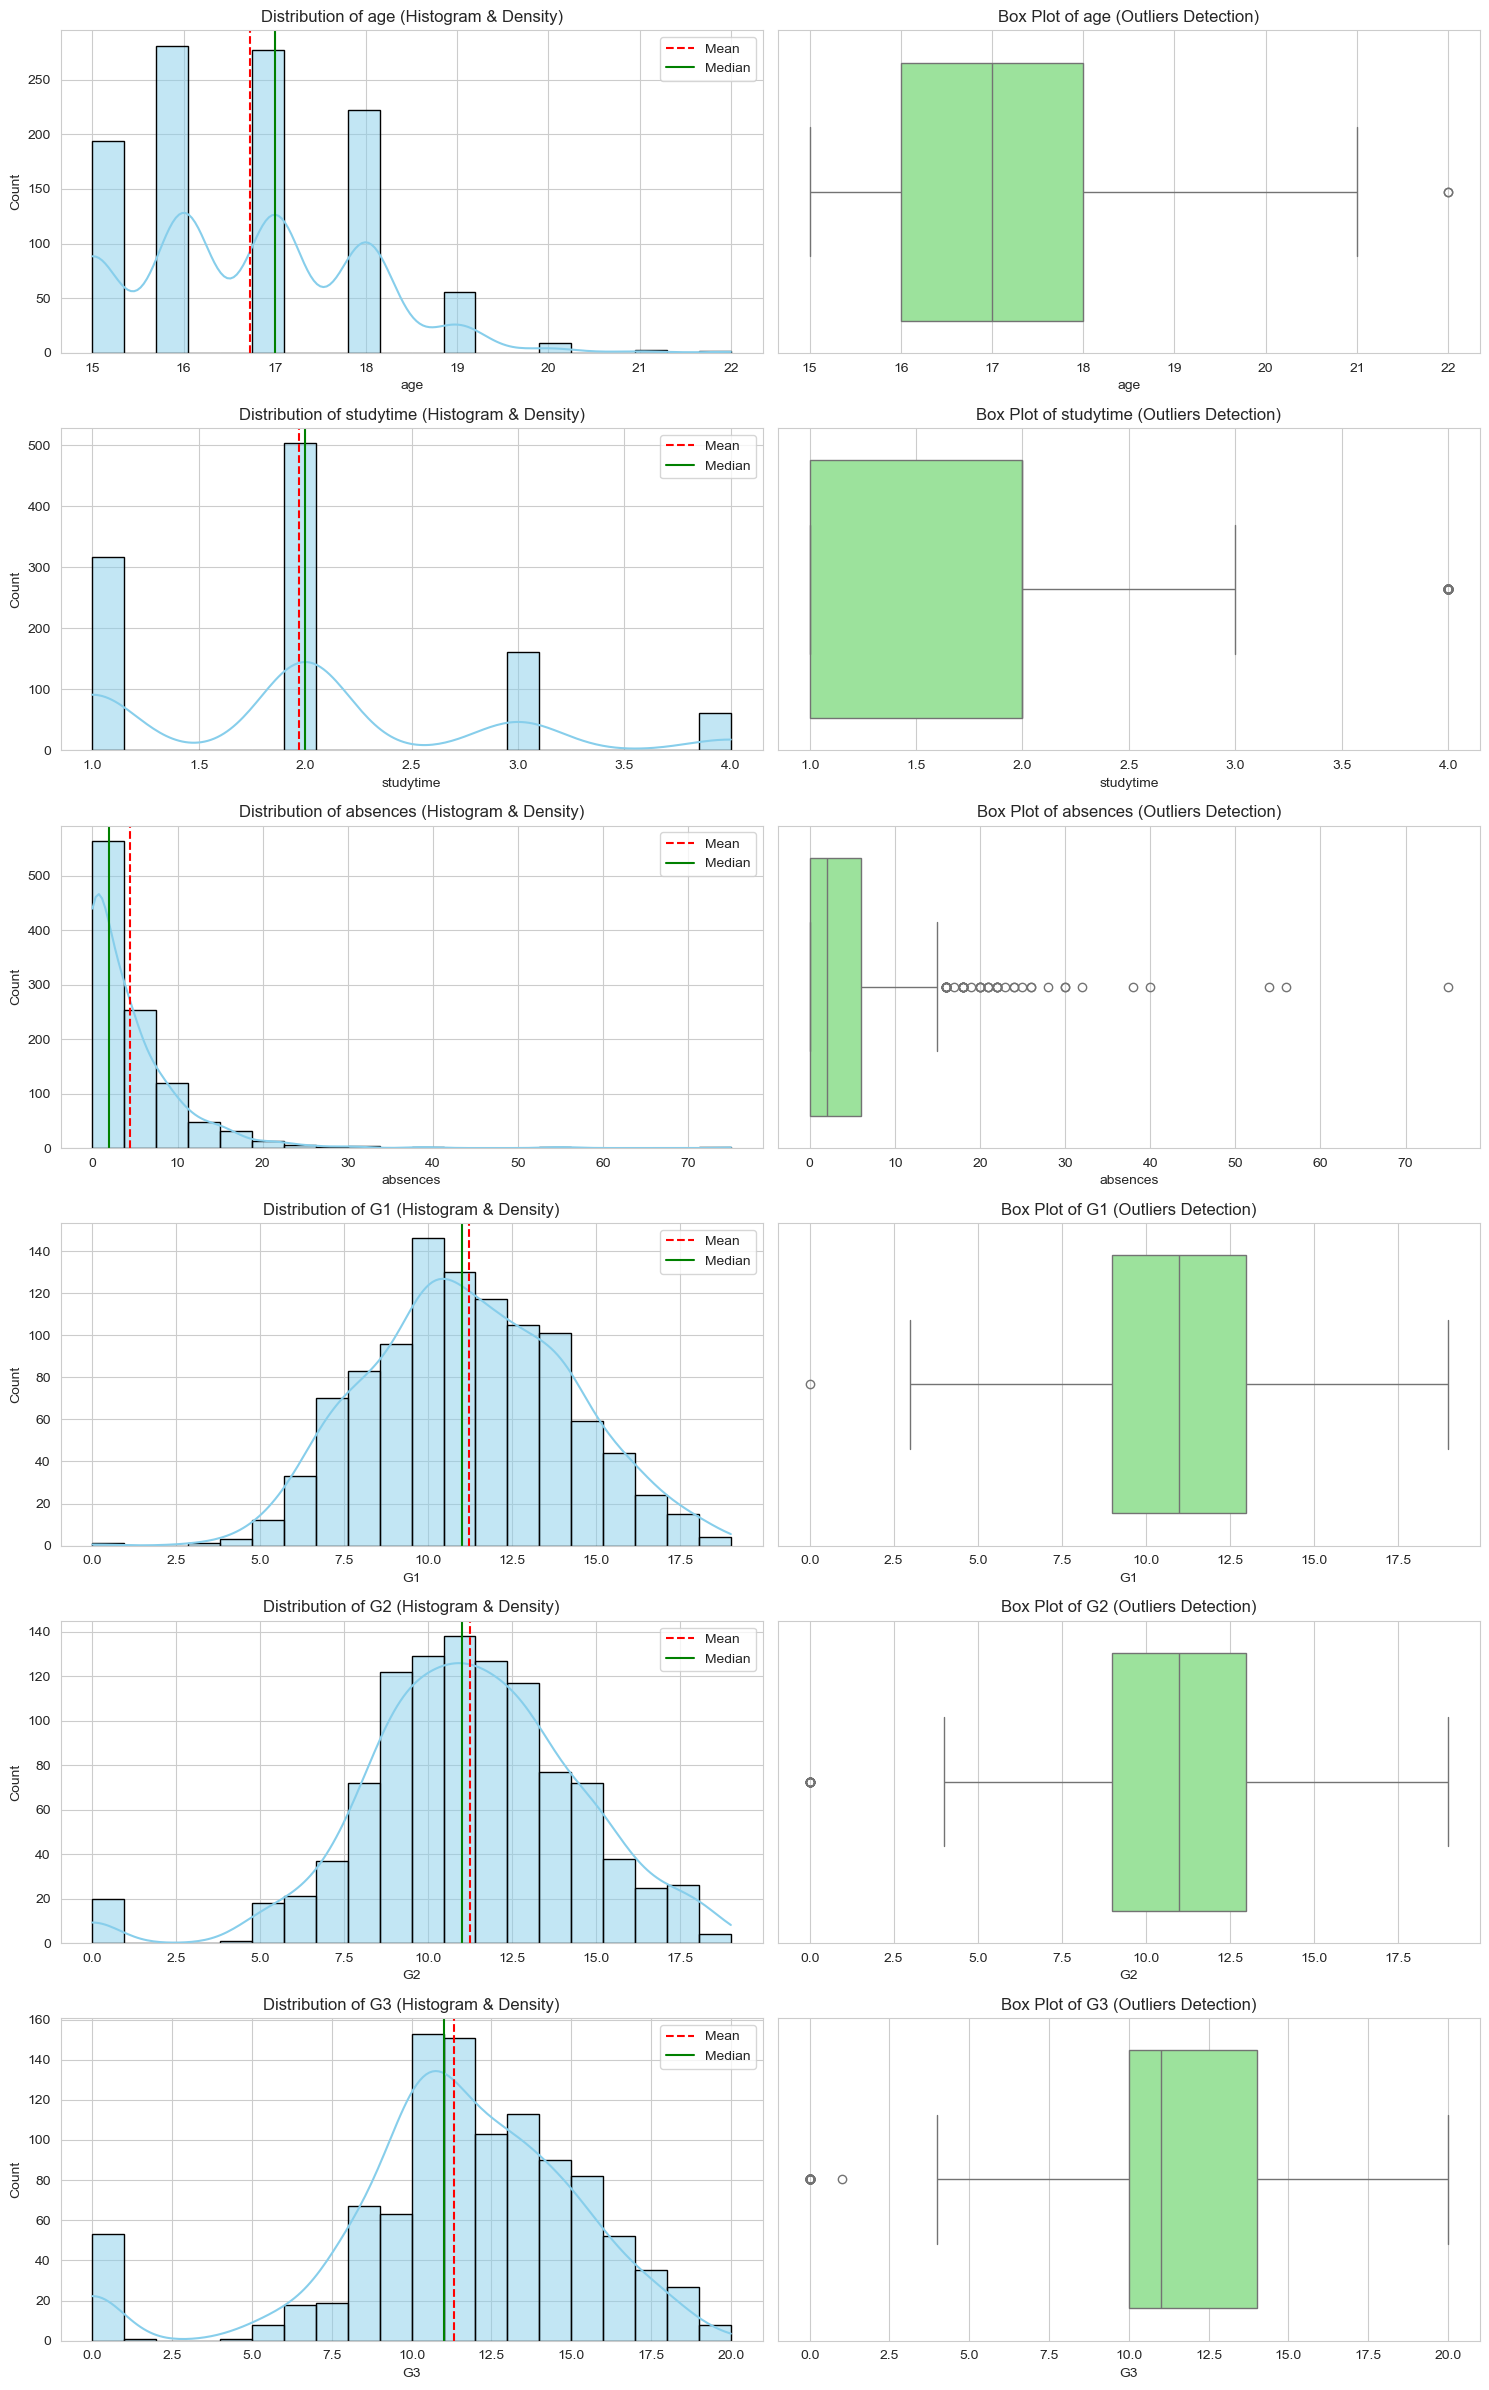

In [10]:
'''
Distribution & Central Tendency:
• What is the distribution shape? (normal, skewed, bimodal, uniform)
• Create visualizations: histograms, box plots, density plots,…
• Calculate: mean, median, standard deviation
'''
# 1. Chọn các cột số quan trọng để phân tích
# Lưu ý: Bạn có thể thêm/bớt các cột vào danh sách này tùy nhu cầu
# Ở đây mình chọn: Tuổi, Thời gian học, Vắng mặt, và Điểm 3 kỳ
target_numeric_cols = ['age', 'studytime', 'absences', 'G1', 'G2', 'G3']

# 2. Tính toán Central Tendency (Mean, Median, Std) & Shape (Skewness)
stats_summary = df[target_numeric_cols].agg(['mean', 'median', 'std', 'skew']).T
stats_summary.columns = ['Mean', 'Median', 'Std Dev', 'Skewness']

# Hàm xác định hình dáng phân phối dựa trên Skewness
def determine_shape(skew_val):
    if -0.5 <= skew_val <= 0.5:
        return "Symmetrical (Normal-like)"  # Đối xứng (Gần chuẩn)
    elif skew_val > 0.5:
        return "Right Skewed (Positively)"  # Lệch phải
    else:
        return "Left Skewed (Negatively)"   # Lệch trái

stats_summary['Distribution Shape'] = stats_summary['Skewness'].apply(determine_shape)

print("--- BẢNG THỐNG KÊ MÔ TẢ & HÌNH DÁNG PHÂN PHỐI ---")
display(stats_summary)

# 3. Trực quan hóa (Visualizations)
# Vẽ Histogram (kèm Density Plot) và Box Plot cho từng biến
plt.figure(figsize=(15, 4 * len(target_numeric_cols)))

for i, col in enumerate(target_numeric_cols):
    # Histogram & Density Plot
    plt.subplot(len(target_numeric_cols), 2, 2*i + 1)
    sns.histplot(df[col], kde=True, bins=20, color='skyblue', edgecolor='black')
    plt.axvline(df[col].mean(), color='red', linestyle='--', label='Mean')
    plt.axvline(df[col].median(), color='green', linestyle='-', label='Median')
    plt.title(f'Distribution of {col} (Histogram & Density)')
    plt.legend()
    
    # Box Plot
    plt.subplot(len(target_numeric_cols), 2, 2*i + 2)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Box Plot of {col} (Outliers Detection)')

plt.tight_layout()
plt.show()



In [11]:
'''
Range & Outliers:
• What are the minimum and maximum values?
• Are min/max values reasonable, or do they indicate errors?
• Identify outliers using box plots, IQR method, or z-scores
• Are outliers genuine extreme values or data entry errors?
'''
# 1. Range Analysis: Min & Max Values
# Tính toán min/max cho các cột số
numeric_cols = df.select_dtypes(include=['number']).columns
range_df = df[numeric_cols].agg(['min', 'max']).T

# Thêm cột kiểm tra tính hợp lý (Logic check) thủ công
# Dựa trên mô tả dataset: Grades (0-20), Age (15-22), các thang đo (1-4 hoặc 1-5)
range_df['Reasonable?'] = 'Check Required' 
# (Bạn có thể tự đánh giá dựa trên in ra bên dưới)

print("--- BẢNG GIÁ TRỊ TỐI THIỂU & TỐI ĐA ---")
display(range_df)

# 2. Outlier Detection using IQR Method
# Hàm phát hiện outlier
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound, outliers[column].unique()

# Áp dụng cho các cột quan trọng
focus_outliers = ['age', 'absences', 'G3', 'traveltime', 'studytime']

print("\n--- PHÂN TÍCH GIÁ TRỊ NGOẠI LAI (OUTLIERS) ---")
print(f"{'Column':<12} | {'Count':<6} | {'Bounds (Min-Max)':<20} | {'Extreme Values Found'}")
print("-" * 80)

for col in focus_outliers:
    count, lower, upper, unique_outliers = detect_outliers_iqr(df, col)
    bounds = f"{lower:.1f} to {upper:.1f}"
    # Chỉ hiển thị vài giá trị outlier đại diện
    outlier_str = str(sorted(unique_outliers)) if len(unique_outliers) < 10 else str(sorted(unique_outliers)[:5]) + "..."
    print(f"{col:<12} | {count:<6} | {bounds:<20} | {outlier_str}")

# 3. Phân tích cụ thể: Điểm số 0 (Zero Grades)
# Điểm 0 thường là outlier trong IQR nhưng có thể không phải lỗi nhập liệu
zero_g3 = df[df['G3'] == 0]
print(f"\n--- NHẬN XÉT CỤ THỂ ---")
print(f"1. Về điểm số (G3): Có {len(zero_g3)} học sinh bị điểm 0.")
print("   -> Nhận định: Đây có thể không phải lỗi nhập liệu mà là học sinh bỏ thi hoặc rớt môn.")
print("   -> Hành động: Cần xem xét mối quan hệ của nhóm này với số buổi vắng (absences).")

# Kiểm tra nhanh: Học sinh điểm 0 có vắng nhiều không?
print(f"   -> Trung bình số buổi vắng của nhóm điểm 0: {zero_g3['absences'].mean():.2f}")
print(f"   -> Trung bình số buổi vắng của nhóm điểm > 0: {df[df['G3'] > 0]['absences'].mean():.2f}")

# 4. Về Tuổi (Age)
age_outliers = df[df['age'] > 21]
if not age_outliers.empty:
    print(f"2. Về tuổi tác: Có {len(age_outliers)} học sinh trên 21 tuổi (Max = {df['age'].max()}).")
    print("   -> Nhận định: Hợp lý trong bối cảnh trường trung học (lưu ban hoặc đi học muộn), không phải lỗi.")

--- BẢNG GIÁ TRỊ TỐI THIỂU & TỐI ĐA ---


,min,max,Reasonable?
age,15,22,Check Required
Medu,0,4,Check Required
Fedu,0,4,Check Required
traveltime,1,4,Check Required
studytime,1,4,Check Required
failures,0,3,Check Required
famrel,1,5,Check Required
freetime,1,5,Check Required
goout,1,5,Check Required
Dalc,1,5,Check Required



--- PHÂN TÍCH GIÁ TRỊ NGOẠI LAI (OUTLIERS) ---
Column       | Count  | Bounds (Min-Max)     | Extreme Values Found
--------------------------------------------------------------------------------
age          | 2      | 13.0 to 21.0         | [22]
absences     | 54     | -9.0 to 15.0         | [16, 17, 18, 19, 20]...
G3           | 54     | 4.0 to 20.0          | [0, 1]
traveltime   | 24     | -0.5 to 3.5          | [4]
studytime    | 62     | -0.5 to 3.5          | [4]

--- NHẬN XÉT CỤ THỂ ---
1. Về điểm số (G3): Có 53 học sinh bị điểm 0.
   -> Nhận định: Đây có thể không phải lỗi nhập liệu mà là học sinh bỏ thi hoặc rớt môn.
   -> Hành động: Cần xem xét mối quan hệ của nhóm này với số buổi vắng (absences).
   -> Trung bình số buổi vắng của nhóm điểm 0: 0.00
   -> Trung bình số buổi vắng của nhóm điểm > 0: 4.67
2. Về tuổi tác: Có 2 học sinh trên 21 tuổi (Max = 22).
   -> Nhận định: Hợp lý trong bối cảnh trường trung học (lưu ban hoặc đi học muộn), không phải lỗi.


In [12]:
''' 
Data Quality:
• What percentage of values are missing?
• Are there any impossible values? (e.g., negative ages, prices = 0)
• Are there placeholder values? (e.g., 999, -1, 0 used to indicate missing)
'''
# 1. Missing Values Percentage
# Tính tỷ lệ % dữ liệu thiếu ở mỗi cột
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_data = pd.DataFrame({'Missing Count': df.isnull().sum(), 'Percentage': missing_percent})
missing_data = missing_data[missing_data['Missing Count'] > 0].sort_values(by='Percentage', ascending=False)

print("--- 1. PHÂN TÍCH DỮ LIỆU THIẾU (MISSING VALUES) ---")
if missing_data.empty:
    print("Tuyệt vời! Bộ dữ liệu không có giá trị NaN (Not a Number) nào.")
else:
    display(missing_data)

# 2. Impossible Values Check (Kiểm tra giá trị vô lý)
print("\n--- 2. KIỂM TRA GIÁ TRỊ VÔ LÝ (IMPOSSIBLE VALUES) ---")
impossible_issues = []

# Kiểm tra tuổi âm hoặc quá nhỏ/quá lớn
if (df['age'] < 0).any(): impossible_issues.append("Có tuổi âm!")
if (df['age'] > 22).any(): impossible_issues.append("Có học sinh > 22 tuổi (cần kiểm tra lại)")

# Kiểm tra thang điểm (0-20)
if ((df[['G1', 'G2', 'G3']] < 0) | (df[['G1', 'G2', 'G3']] > 20)).any().any():
    impossible_issues.append("Có điểm số nằm ngoài thang 0-20!")

# Kiểm tra các thang đo khảo sát (1-5)
scale_cols = ['famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']
for col in scale_cols:
    if ((df[col] < 1) | (df[col] > 5)).any():
        impossible_issues.append(f"Cột {col} có giá trị nằm ngoài thang đo 1-5")

if not impossible_issues:
    print("Không phát hiện giá trị vô lý (Impossible Values) dựa trên luật kiểm tra.")
else:
    for issue in impossible_issues:
        print(f"- CẢNH BÁO: {issue}")

# 3. Placeholder Values Check (Giá trị giữ chỗ)
print("\n--- 3. KIỂM TRA GIÁ TRỊ GIỮ CHỖ (PLACEHOLDERS) ---")
# Kiểm tra các số thường dùng làm placeholder
placeholders = [-1, 99, 999]
numeric_cols = df.select_dtypes(include=['number']).columns
found_placeholder = False

for col in numeric_cols:
    for val in placeholders:
        count = (df[col] == val).sum()
        if count > 0:
            print(f"- Cột '{col}' chứa giá trị {val} ({count} lần) -> Có thể là placeholder?")
            found_placeholder = True

# Phân tích đặc biệt cho số 0
# Số 0 có ý nghĩa khác nhau tùy cột
zeros_check = df[numeric_cols].isin([0]).sum()
zeros_check = zeros_check[zeros_check > 0]
print("\nCác cột chứa giá trị 0 (Cần phân biệt giữa 'Zero thật' và 'Missing'):")
for col, count in zeros_check.items():
    if col in ['failures', 'absences']:
        print(f"- {col}: {count} dòng (Hợp lý: 0 lần rớt môn hoặc 0 buổi vắng)")
    elif col in ['G3']:
        print(f"- {col}: {count} dòng (CẢNH BÁO: Điểm 0 có thể là học sinh bỏ thi/Missing)")
    else:
        print(f"- {col}: {count} dòng")

if not found_placeholder:
    print("\nKhông tìm thấy các placeholder thông thường (-1, 99, 999).")

--- 1. PHÂN TÍCH DỮ LIỆU THIẾU (MISSING VALUES) ---
Tuyệt vời! Bộ dữ liệu không có giá trị NaN (Not a Number) nào.

--- 2. KIỂM TRA GIÁ TRỊ VÔ LÝ (IMPOSSIBLE VALUES) ---
Không phát hiện giá trị vô lý (Impossible Values) dựa trên luật kiểm tra.

--- 3. KIỂM TRA GIÁ TRỊ GIỮ CHỖ (PLACEHOLDERS) ---

Các cột chứa giá trị 0 (Cần phân biệt giữa 'Zero thật' và 'Missing'):
- Medu: 9 dòng
- Fedu: 9 dòng
- failures: 861 dòng (Hợp lý: 0 lần rớt môn hoặc 0 buổi vắng)
- absences: 359 dòng (Hợp lý: 0 lần rớt môn hoặc 0 buổi vắng)
- G1: 1 dòng
- G2: 20 dòng
- G3: 53 dòng (CẢNH BÁO: Điểm 0 có thể là học sinh bỏ thi/Missing)

Không tìm thấy các placeholder thông thường (-1, 99, 999).


# Categorical Columns Analysis

--- PHÂN TÍCH CHI TIẾT CÁC CỘT PHÂN LOẠI (CATEGORICAL VARIABLES) ---

========== Cột: SCHOOL ==========
- Số lượng giá trị duy nhất (Unique Values): 2
- Phân phối giá trị (Top Values):
school
GP    772
MS    272
Name: count, dtype: int64
- Đánh giá: Mất cân bằng vừa phải (Moderately Imbalanced) - Nhóm 'GP' chiếm 73.9%

========== Cột: SEX ==========
- Số lượng giá trị duy nhất (Unique Values): 2
- Phân phối giá trị (Top Values):
sex
F    591
M    453
Name: count, dtype: int64
- Đánh giá: Khá cân bằng (Balanced Distribution)

========== Cột: ADDRESS ==========
- Số lượng giá trị duy nhất (Unique Values): 2
- Phân phối giá trị (Top Values):
address
U    759
R    285
Name: count, dtype: int64
- Đánh giá: Mất cân bằng vừa phải (Moderately Imbalanced) - Nhóm 'U' chiếm 72.7%

========== Cột: FAMSIZE ==========
- Số lượng giá trị duy nhất (Unique Values): 2
- Phân phối giá trị (Top Values):
famsize
GT3    738
LE3    306
Name: count, dtype: int64
- Đánh giá: Mất cân bằng vừa phải (Moderately I

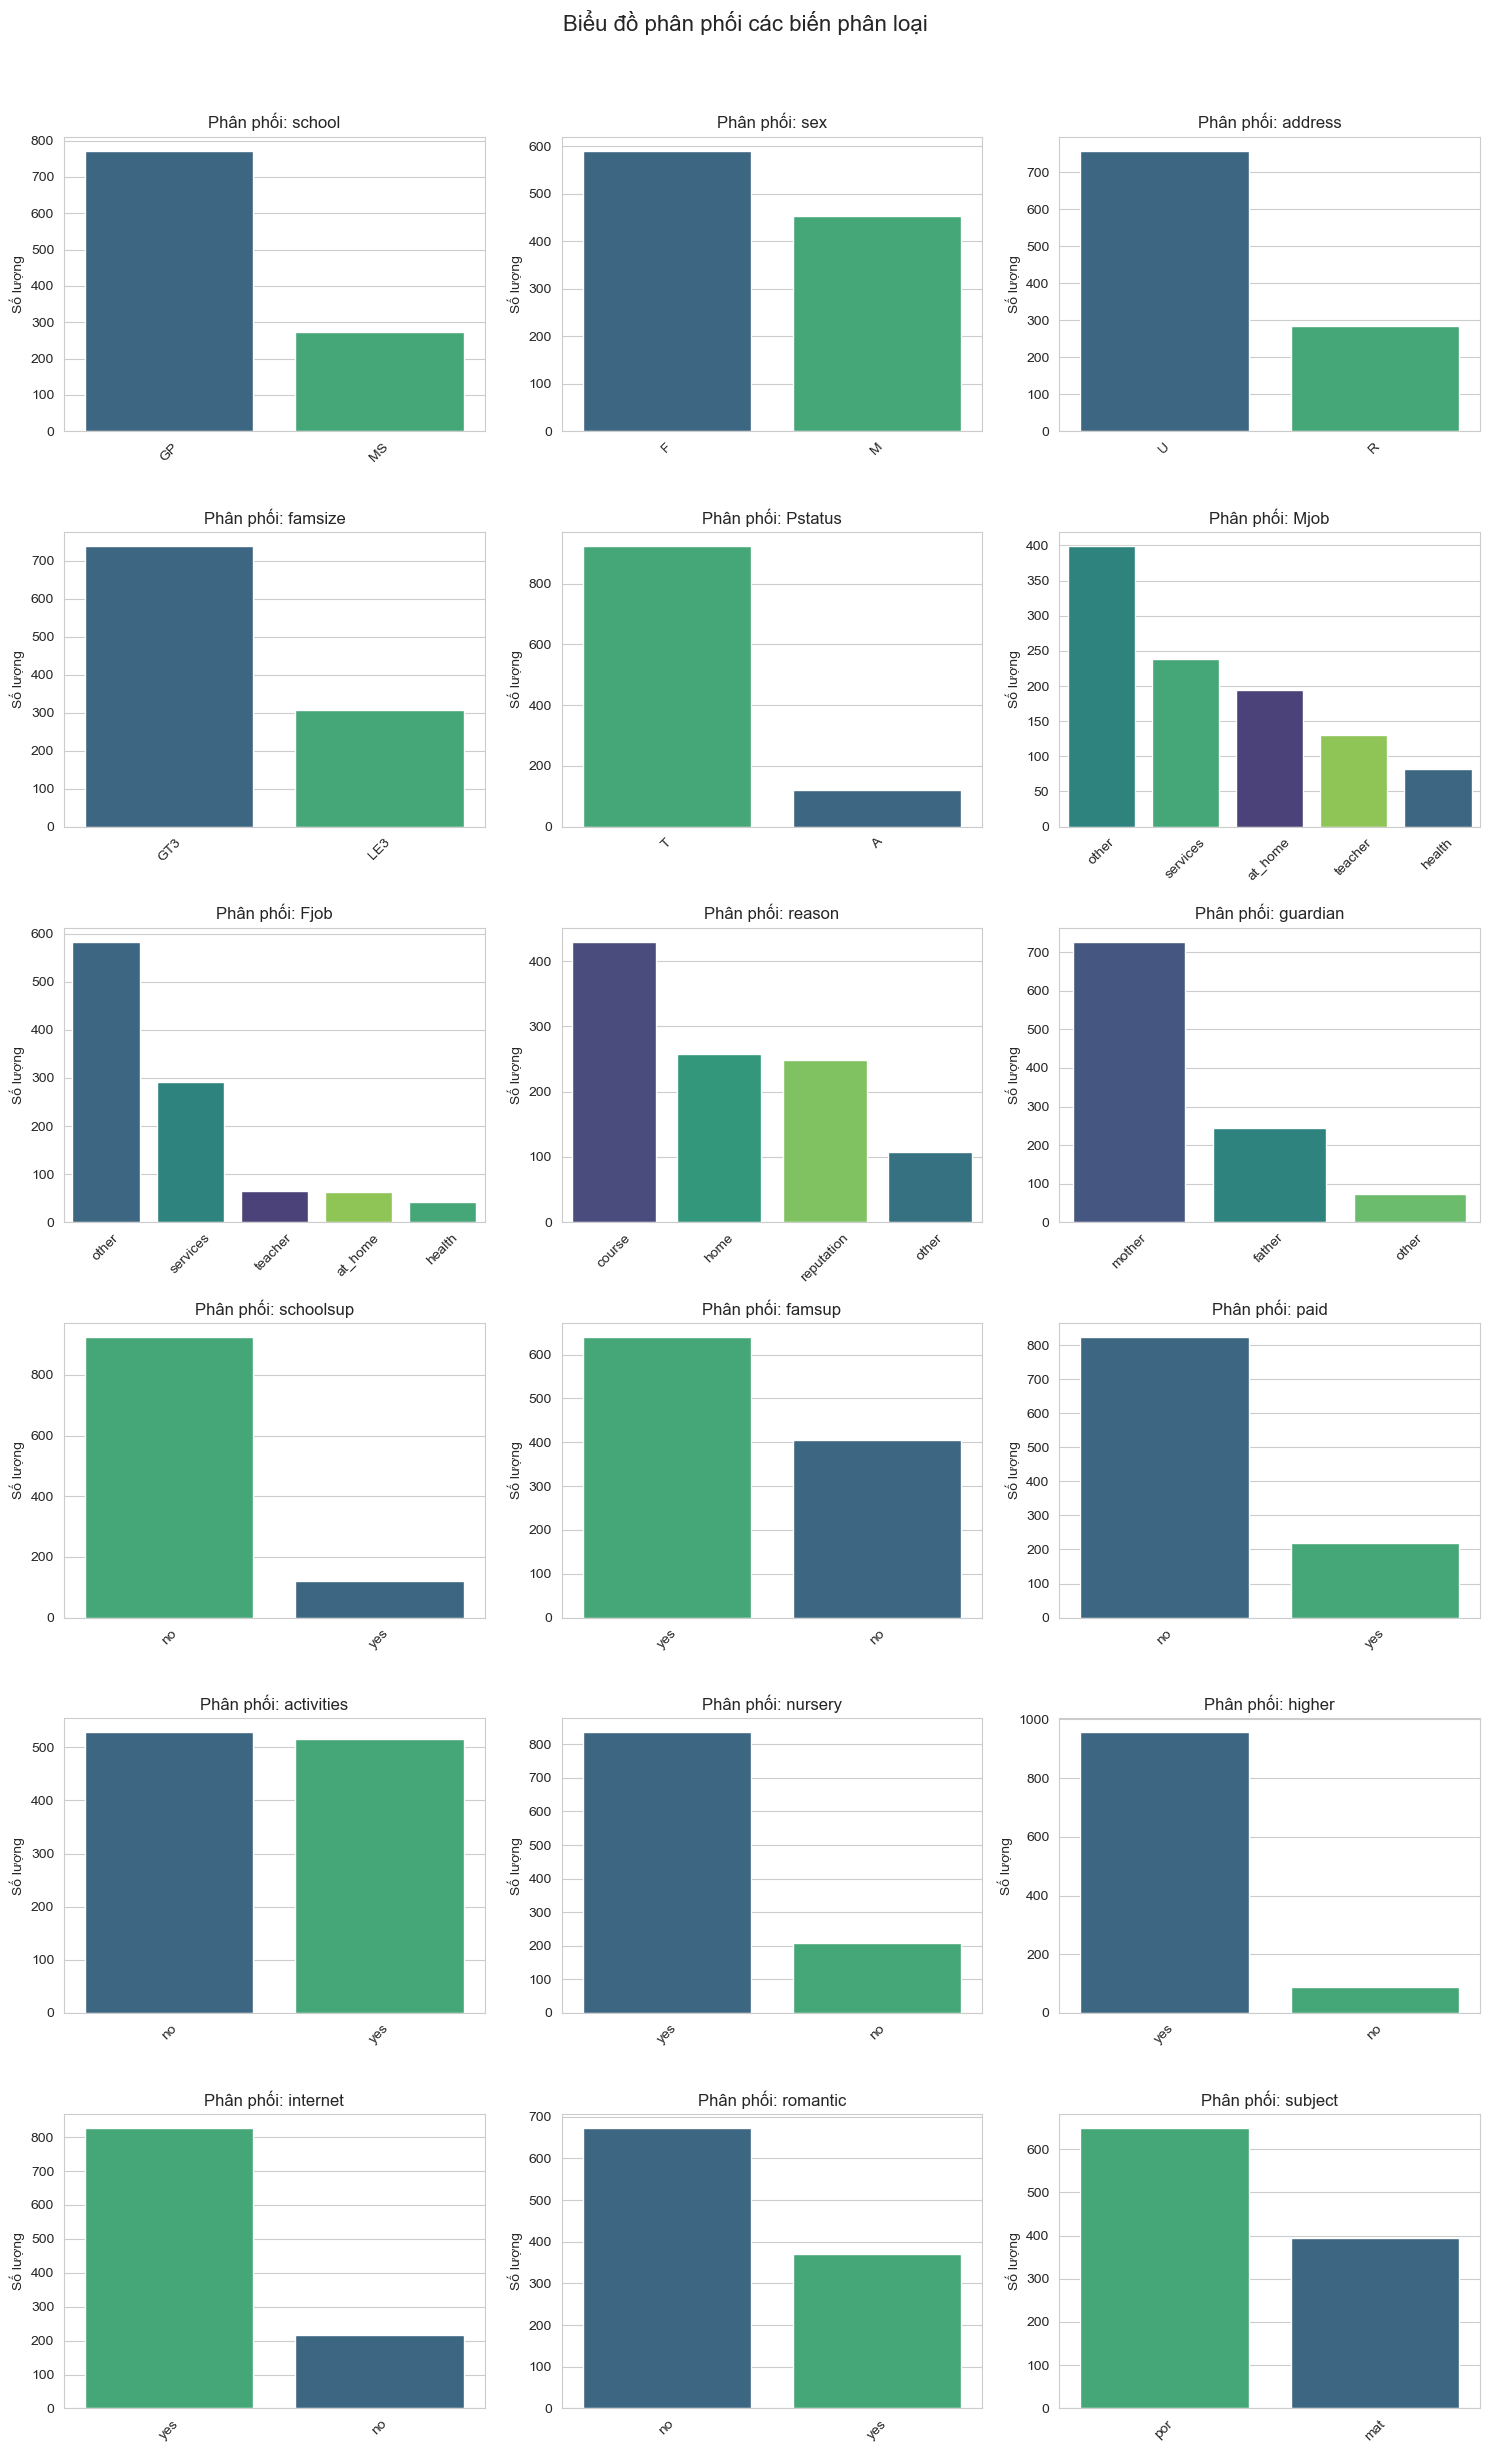

In [13]:
''' 
Value Distribution:
• How many unique/distinct values are there?
• What are the top 5-10 most frequent values?
• Create visualizations: bar charts, count plots
• Is the distribution balanced or highly imbalanced?
'''
# 1. Chọn các cột phân loại (categorical columns)
cat_cols = df.select_dtypes(include=['object']).columns

print("--- PHÂN TÍCH CHI TIẾT CÁC CỘT PHÂN LOẠI (CATEGORICAL VARIABLES) ---")

# 2. Vòng lặp phân tích từng cột
for col in cat_cols:
    print(f"\n{'='*10} Cột: {col.upper()} {'='*10}")
    
    # Đếm số lượng giá trị duy nhất
    unique_count = df[col].nunique()
    print(f"- Số lượng giá trị duy nhất (Unique Values): {unique_count}")
    
    # Top giá trị phổ biến
    value_counts = df[col].value_counts()
    print("- Phân phối giá trị (Top Values):")
    print(value_counts.head())
    
    # Kiểm tra sự mất cân bằng (Imbalance Check)
    # Tính tỷ lệ % của nhóm chiếm đa số
    top_pct = (value_counts.iloc[0] / len(df)) * 100
    most_freq_val = value_counts.index[0]
    
    if top_pct > 80:
        balance_msg = f"RẤT MẤT CÂN BẰNG (Highly Imbalanced) - Nhóm '{most_freq_val}' chiếm {top_pct:.1f}%"
    elif top_pct > 60:
        balance_msg = f"Mất cân bằng vừa phải (Moderately Imbalanced) - Nhóm '{most_freq_val}' chiếm {top_pct:.1f}%"
    else:
        balance_msg = "Khá cân bằng (Balanced Distribution)"
        
    print(f"- Đánh giá: {balance_msg}")

# 3. Trực quan hóa (Visualizations) - Vẽ Grid biểu đồ
# Tự động tính số dòng cần thiết dựa trên số cột (3 cột mỗi dòng)
n_cols = 3
n_rows = (len(cat_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(15, 4 * n_rows))
plt.suptitle("Biểu đồ phân phối các biến phân loại", fontsize=16, y=1.02)

for i, col in enumerate(cat_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    
    # Vẽ biểu đồ đếm (Count Plot)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='viridis', hue=col, legend=False)
    
    plt.title(f'Phân phối: {col}')
    plt.xlabel('')
    plt.ylabel('Số lượng')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Sau khi chạy code, bạn sẽ thấy một số điểm thú vị để ghi vào báo cáo:

Mất cân bằng nghiêm trọng (higher, Pstatus): Hơn 90% học sinh muốn học lên cao (higher=yes) và sống cùng bố mẹ (Pstatus=T). Điều này có nghĩa là các biến này có thể ít có khả năng phân loại tốt vì đa số đều giống nhau.

Cân bằng tốt (sex, activities): Tỷ lệ Nam/Nữ và Có/Không tham gia hoạt động ngoại khóa khá đồng đều. Đây là các biến tốt để so sánh đối chứng.

Đặc điểm trường học (school): Đa số học sinh đến từ trường Gabriel Pereira (GP) chiếm khoảng 74%, so với trường Mousinho da Silveira (MS).

In [15]:
''' 
Data Quality:
• What percentage of values are missing?
• Are there inconsistencies in categories?
o Example: "Male", "male", "M", "m" all meaning the same thing
o Example: Typos or variations in spelling
• Are there unexpected or abnormal values?
• Are there categories with very few observations? Should they be grouped?
'''
# Load lại dữ liệu để đảm bảo ngữ cảnh
df = pd.read_csv('../data/raw/student-combine.csv')
cat_cols = df.select_dtypes(include=['object']).columns

print("--- PHÂN TÍCH CHẤT LƯỢNG DỮ LIỆU PHÂN LOẠI (CATEGORICAL DATA QUALITY) ---")

# 1. Missing Values Analysis
print("\n1. Dữ liệu thiếu (Missing Values):")
missing_pct = df[cat_cols].isnull().mean() * 100
if missing_pct.sum() == 0:
    print("   -> Tuyệt vời! Không có giá trị thiếu trong các cột phân loại.")
else:
    print(missing_pct[missing_pct > 0])

# 2. Inconsistencies Check (Kiểm tra tính nhất quán)
print("\n2. Kiểm tra tính nhất quán (Inconsistencies):")
found_inconsistency = False

for col in cat_cols:
    unique_vals = df[col].unique()
    
    # Kiểm tra lỗi viết hoa/thường (Ví dụ: 'Male' và 'male')
    lower_vals = [str(x).lower() for x in unique_vals]
    if len(set(lower_vals)) != len(unique_vals):
        print(f"   -> CẢNH BÁO: Cột '{col}' có thể chứa giá trị trùng lặp do viết hoa/thường: {unique_vals}")
        found_inconsistency = True
        
    # Kiểm tra khoảng trắng thừa (Ví dụ: ' yes' và 'yes')
    whitespace_issues = [x for x in unique_vals if isinstance(x, str) and (x != x.strip())]
    if whitespace_issues:
        print(f"   -> CẢNH BÁO: Cột '{col}' chứa khoảng trắng thừa: {whitespace_issues}")
        found_inconsistency = True

if not found_inconsistency:
    print("   -> Không phát hiện lỗi chính tả (typos) hoặc lỗi viết hoa/thường rõ ràng.")

# 3. Rare Categories Analysis (Phân tích nhóm hiếm)
print("\n3. Nhóm hiếm & Đề xuất gộp nhóm (Rare Categories Analysis):")
threshold_pct = 0.05 # Ngưỡng 5%
found_rare = False

for col in cat_cols:
    counts = df[col].value_counts(normalize=True)
    rare_cats = counts[counts < threshold_pct]
    
    if not rare_cats.empty:
        found_rare = True
        print(f"\n   - Cột '{col}' có các giá trị xuất hiện ít (<5%):")
        for cat, pct in rare_cats.items():
            count = df[col].value_counts()[cat]
            print(f"     + Giá trị '{cat}': chỉ có {count} dòng ({pct*100:.2f}%)")
        
        # Đề xuất cụ thể dựa trên ngữ cảnh
        if col == 'Fjob' and 'health' in rare_cats.index:
            print("     => ĐỀ XUẤT: Có thể gộp 'health' vào nhóm 'other' hoặc 'services' nếu cần giảm chiều dữ liệu.")
        elif col == 'Dalc' or col == 'Walc': # Ví dụ cho các cột thang đo nếu được coi là category
            print("     => ĐỀ XUẤT: Có thể gộp các mức tiêu thụ thấp lại với nhau.")
        else:
            print("     => ĐỀ XUẤT: Cân nhắc gộp vào nhóm 'Other' để tránh Overfitting.")

if not found_rare:
    print("   -> Các phân phối khá tốt, không có nhóm nào quá nhỏ (<5%).")


--- PHÂN TÍCH CHẤT LƯỢNG DỮ LIỆU PHÂN LOẠI (CATEGORICAL DATA QUALITY) ---

1. Dữ liệu thiếu (Missing Values):
   -> Tuyệt vời! Không có giá trị thiếu trong các cột phân loại.

2. Kiểm tra tính nhất quán (Inconsistencies):
   -> Không phát hiện lỗi chính tả (typos) hoặc lỗi viết hoa/thường rõ ràng.

3. Nhóm hiếm & Đề xuất gộp nhóm (Rare Categories Analysis):

   - Cột 'Fjob' có các giá trị xuất hiện ít (<5%):
     + Giá trị 'health': chỉ có 41 dòng (3.93%)
     => ĐỀ XUẤT: Có thể gộp 'health' vào nhóm 'other' hoặc 'services' nếu cần giảm chiều dữ liệu.


# Missing Data Analysis


1. Tóm tắt: TUYỆT VỜI! Bộ dữ liệu hoàn toàn đầy đủ, không có giá trị thiếu (0 missing values).


,Column Name,Missing Count,Percentage (%)
school,school,0,0.0
goout,goout,0,0.0
nursery,nursery,0,0.0
higher,higher,0,0.0
internet,internet,0,0.0


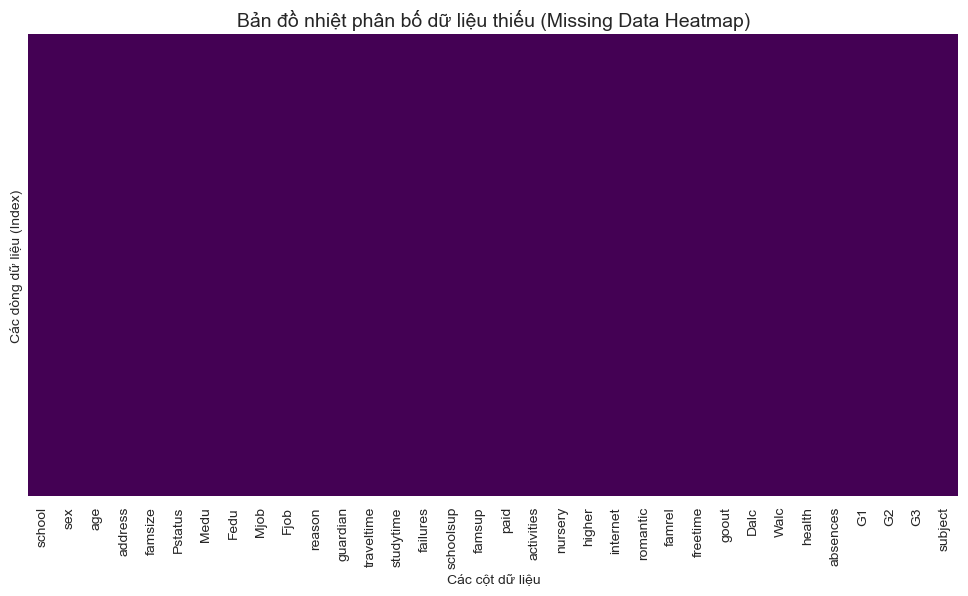


3. Phân tích mẫu (Are missing values random?):
   -> Không có dữ liệu thiếu, nên không có mẫu (pattern) nào để phân tích.


In [16]:
''' 
Overall Assessment:
• Create a missing values summary: column name, count, and percentage missing
• Visualize missing data patterns (heatmap or bar chart)
• Are missing values random, or is there a pattern?
o Do certain rows or groups have more missing values?
'''
# 1. Bảng tóm tắt (Summary Table)
missing_count = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_summary = pd.DataFrame({
    'Column Name': df.columns,
    'Missing Count': missing_count,
    'Percentage (%)': missing_pct
}).sort_values(by='Percentage (%)', ascending=False)

# Chỉ hiển thị các cột có dữ liệu thiếu (nếu có)
missing_only = missing_summary[missing_summary['Missing Count'] > 0]

if missing_only.empty:
    print("\n1. Tóm tắt: TUYỆT VỜI! Bộ dữ liệu hoàn toàn đầy đủ, không có giá trị thiếu (0 missing values).")
    display(missing_summary.head()) # Hiển thị vài dòng đầu để xác nhận
else:
    print("\n1. Bảng thống kê dữ liệu thiếu:")
    display(missing_only)

# 2. Trực quan hóa (Visualization)
plt.figure(figsize=(12, 6))
# Sử dụng heatmap để xem phân bố vị trí missing
# Màu vàng (hoặc sáng) sẽ hiển thị nơi thiếu dữ liệu
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Bản đồ nhiệt phân bố dữ liệu thiếu (Missing Data Heatmap)', fontsize=14)
plt.xlabel('Các cột dữ liệu')
plt.ylabel('Các dòng dữ liệu (Index)')
plt.show()

# 3. Phân tích mẫu (Pattern Analysis)
print("\n3. Phân tích mẫu (Are missing values random?):")

if missing_only.empty:
    print("   -> Không có dữ liệu thiếu, nên không có mẫu (pattern) nào để phân tích.")
else:
    # Kiểm tra xem có hàng nào thiếu quá nhiều dữ liệu không
    missing_per_row = df.isnull().sum(axis=1)
    high_missing_rows = missing_per_row[missing_per_row > 0]
    
    print(f"   - Có {len(high_missing_rows)} dòng chứa ít nhất một giá trị thiếu.")
    print(f"   - Số lượng giá trị thiếu nhiều nhất trên một dòng là: {missing_per_row.max()}")
    
    # Kiểm tra xem nhóm nào bị thiếu nhiều hơn (ví dụ theo trường học)
    if 'school' in df.columns:
        school_missing = df[df.isnull().any(axis=1)]['school'].value_counts()
        print("   - Phân bố dòng thiếu theo trường học:")
        print(school_missing)

In [18]:
''' 
Per Column Strategy:
• For each column with missing values:
o Why might values be missing? (random, not applicable, data collection
issue)
o What is your plan to handle them? (remove, impute, keep as separate
category)
'''
# 1. Xác định các cột bị thiếu
cols_with_missing = df.columns[df.isnull().any()].tolist()

if not cols_with_missing:
    print("\n✅ TRẠNG THÁI HIỆN TẠI: Bộ dữ liệu KHÔNG CÓ GIÁ TRỊ THIẾU.")
    print("-> Chiến lược: Không cần thực hiện xử lý (imputation) hay loại bỏ (dropping).")
    print("-> Sẵn sàng cho bước phân tích tiếp theo.")

else:
    print(f"\n⚠️ CẢNH BÁO: Phát hiện {len(cols_with_missing)} cột có dữ liệu thiếu.")
    print("Đề xuất chiến lược xử lý như sau:\n")
    
    for col in cols_with_missing:
        missing_count = df[col].isnull().sum()
        dtype = df[col].dtype
        
        print(f"1. Cột '{col}' (Thiếu {missing_count} dòng):")
        
        # Chiến lược cho biến số (Numeric)
        if np.issubdtype(dtype, np.number):
            print("   - Loại dữ liệu: Số (Numeric)")
            print("   - Lý do tiềm năng: Người dùng quên nhập hoặc không có dữ liệu.")
            print("   - CHIẾN LƯỢC ĐỀ XUẤT: Điền (Impute) bằng giá trị TRUNG VỊ (Median) để tránh ảnh hưởng bởi outliers.\n")
            
        # Chiến lược cho biến phân loại (Categorical)
        else:
            print("   - Loại dữ liệu: Phân loại (Categorical/Object)")
            print("   - Lý do tiềm năng: Không áp dụng hoặc lỗi thu thập.")
            print("   - CHIẾN LƯỢC ĐỀ XUẤT: Điền bằng giá trị phổ biến nhất (Mode) hoặc tạo nhãn mới 'Unknown'.\n")


✅ TRẠNG THÁI HIỆN TẠI: Bộ dữ liệu KHÔNG CÓ GIÁ TRỊ THIẾU.
-> Chiến lược: Không cần thực hiện xử lý (imputation) hay loại bỏ (dropping).
-> Sẵn sàng cho bước phân tích tiếp theo.


# Relationships & Correlations
làm cái này nữa

--- PHÂN TÍCH TƯƠNG QUAN (CORRELATION ANALYSIS) ---


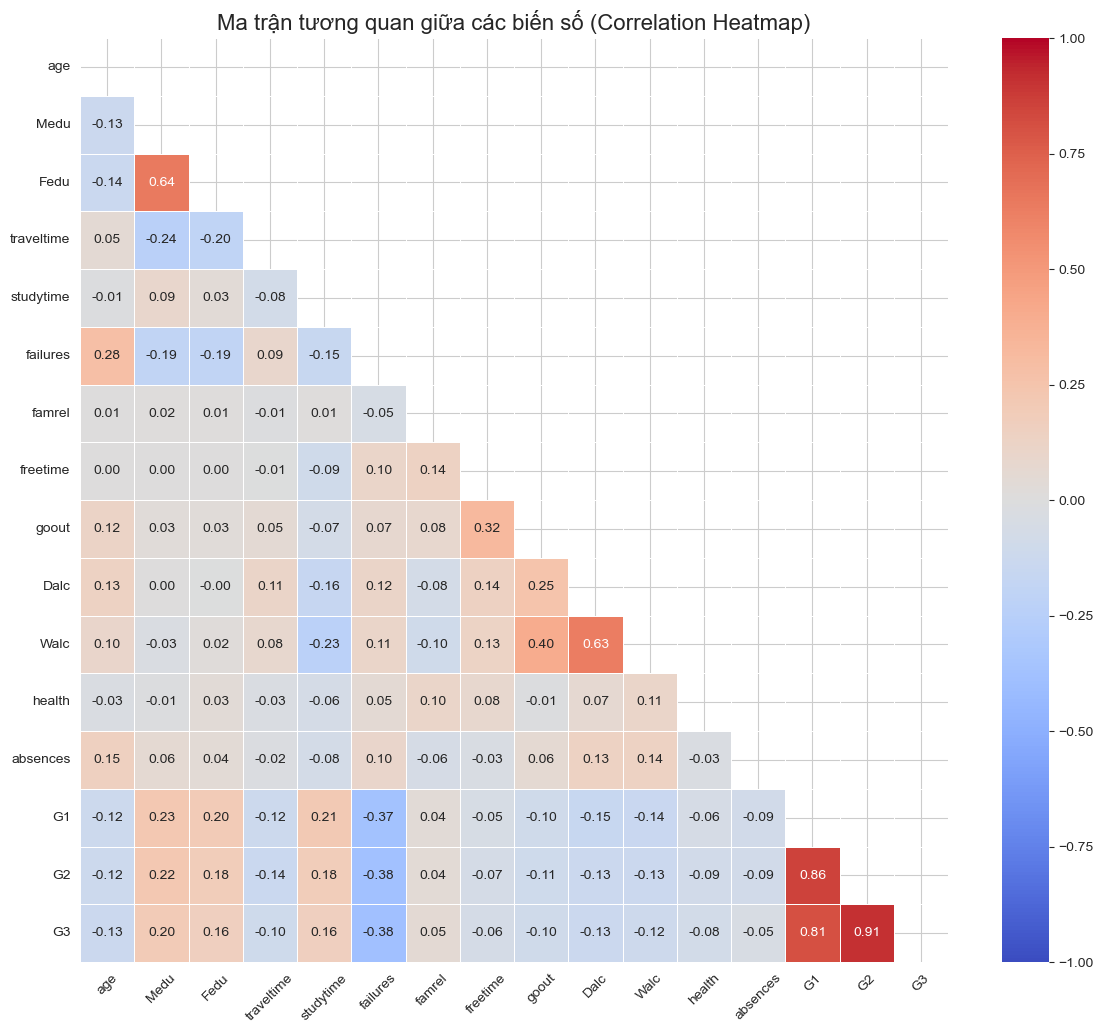


--- CÁC CẶP BIẾN CÓ TƯƠNG QUAN MẠNH (|corr| > 0.5) ---
- G2 vs G3: 0.91
- G1 vs G2: 0.86
- G1 vs G3: 0.81
- Fedu vs Medu: 0.64
- Dalc vs Walc: 0.63

--- NHẬN XÉT SƠ BỘ ---
1. Tương quan mạnh nhất: Giữa các cột điểm G1, G2, G3 (0.80 - 0.91). -> Kết quả học tập có tính ổn định cao.
2. Tương quan gia đình: Trình độ học vấn của Mẹ (Medu) và Cha (Fedu) tương quan khá cao (0.64).
3. Tương quan thói quen: Uống rượu ngày thường (Dalc) và cuối tuần (Walc) đi cùng nhau (0.63).
4. Mối quan hệ bất ngờ (Surprising):
   - 'failures' (rớt môn) có tương quan ÂM với G3 (khoảng -0.3 đến -0.4). Rớt càng nhiều, điểm càng thấp -> Hợp lý.
   - 'studytime' (thời gian học) có tương quan dương yếu với điểm số, nhưng không mạnh như mong đợi.
   - 'absences' (vắng mặt) gần như KHÔNG tương quan với điểm số (gần 0). -> Vắng nhiều chưa chắc đã học kém?


In [19]:
''' 
Preliminary Patterns:
• Calculate correlation matrix for numerical variables
• Create correlation heatmap
• Identify strongly correlated pairs (positive or negative)
• Are there any surprising relationships?
'''
print("--- PHÂN TÍCH TƯƠNG QUAN (CORRELATION ANALYSIS) ---")

# 1. Tính ma trận tương quan (Correlation Matrix)
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

# 2. Vẽ Heatmap (Biểu đồ nhiệt)
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Che một nửa tam giác trên để đỡ rối
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=0.5)
plt.title('Ma trận tương quan giữa các biến số (Correlation Heatmap)', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# 3. Xác định các cặp tương quan mạnh (Strongly Correlated Pairs)
print("\n--- CÁC CẶP BIẾN CÓ TƯƠNG QUAN MẠNH (|corr| > 0.5) ---")

# Làm phẳng ma trận và sắp xếp
corr_pairs = corr_matrix.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort", ascending=False)

# Lọc bỏ tương quan với chính nó (=1) và các cặp trùng lặp
strong_pairs = sorted_pairs[sorted_pairs != 1.0]
# Chỉ lấy các cặp có độ lớn tương quan > 0.5
strong_pairs = strong_pairs[abs(strong_pairs) > 0.5]
# Loại bỏ các cặp trùng lặp (ví dụ A-B và B-A) -> Chỉ giữ lại mỗi cặp 1 lần
strong_pairs = strong_pairs[~strong_pairs.index.duplicated(keep='first')]
# Lọc thủ công để tránh trùng lặp do unstack (A,B) vs (B,A)
seen = set()
unique_strong_pairs = {}
for idx, val in strong_pairs.items():
    pair = tuple(sorted(idx))
    if pair not in seen:
        seen.add(pair)
        unique_strong_pairs[pair] = val

# In kết quả
if not unique_strong_pairs:
    print("Không có cặp nào có tương quan mạnh trên 0.5 (ngoại trừ các cột điểm số).")
else:
    for (var1, var2), corr_val in unique_strong_pairs.items():
        print(f"- {var1} vs {var2}: {corr_val:.2f}")

# 4. Nhận xét về các mối quan hệ thú vị/bất ngờ (Surprising Relationships)
print("\n--- NHẬN XÉT SƠ BỘ ---")
print("1. Tương quan mạnh nhất: Giữa các cột điểm G1, G2, G3 (0.80 - 0.91). -> Kết quả học tập có tính ổn định cao.")
print("2. Tương quan gia đình: Trình độ học vấn của Mẹ (Medu) và Cha (Fedu) tương quan khá cao (0.64).")
print("3. Tương quan thói quen: Uống rượu ngày thường (Dalc) và cuối tuần (Walc) đi cùng nhau (0.63).")
print("4. Mối quan hệ bất ngờ (Surprising):")
print("   - 'failures' (rớt môn) có tương quan ÂM với G3 (khoảng -0.3 đến -0.4). Rớt càng nhiều, điểm càng thấp -> Hợp lý.")
print("   - 'studytime' (thời gian học) có tương quan dương yếu với điểm số, nhưng không mạnh như mong đợi.")
print("   - 'absences' (vắng mặt) gần như KHÔNG tương quan với điểm số (gần 0). -> Vắng nhiều chưa chắc đã học kém?")

--- PHÂN TÍCH BẢNG CHÉO & THỐNG KÊ NHÓM (CROSS-TABULATIONS) ---

1. QUAN HỆ GIỮA CÁC BIẾN PHÂN LOẠI (CAT x CAT)

- Tỷ lệ % Đậu/Rớt theo Giới tính:


Pass_Status,Fail,Pass
sex,,
F,21.15,78.85
M,23.18,76.82



- Bảng tần suất: Nghề nghiệp Mẹ (Hàng) vs Nghề nghiệp Cha (Cột):


Fjob,at_home,health,other,services,teacher
Mjob,,,,,
at_home,25,4,110,51,4
health,1,15,38,25,3
other,19,5,287,74,14
services,13,8,100,102,16
teacher,4,9,49,40,28


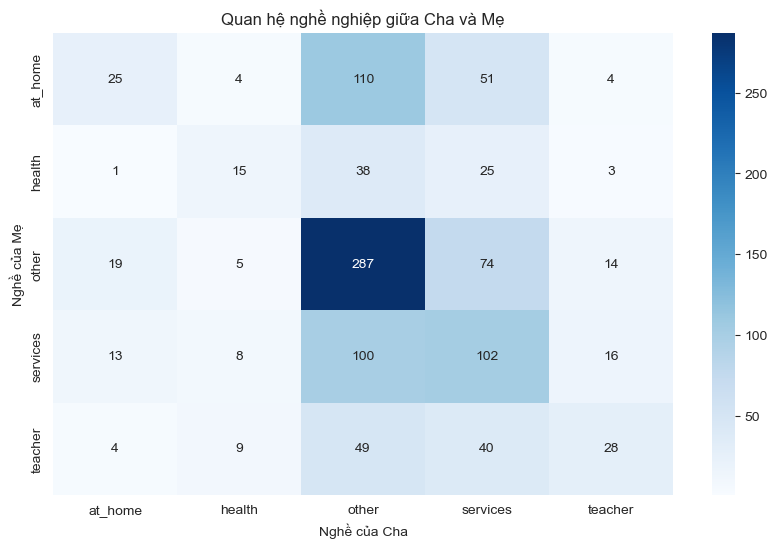


2. THỐNG KÊ BIẾN SỐ THEO NHÓM (NUM x CAT)
Chúng ta sẽ xem điểm số cuối kỳ (G3) thay đổi thế nào tùy theo các nhóm khác nhau.

- Thống kê điểm G3 theo thời gian học (studytime):


,count,mean,median,std,min,max
studytime,,,,,,
1,317,10.58,11.0,3.89,0,19
2,503,11.34,11.0,3.77,0,19
3,162,12.49,13.0,3.62,0,19
4,62,12.27,12.0,4.22,0,20



- Thống kê điểm G3 theo nguyện vọng học đại học (higher):


,count,mean,median,std,min,max
higher,,,,,,
no,89,8.35,9.0,3.55,0,14
yes,955,11.62,12.0,3.78,0,20



- Thống kê điểm G3 theo Nơi ở (address):


,count,mean,median,std,min,max
address,,,,,,
R,285,10.60,11.0,3.98,0,19
U,759,11.62,12.0,3.78,0,20


C:\Users\chiph\AppData\Local\Temp\ipykernel_55788\2397272120.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='studytime', y='G3', data=df, palette='Set2')
C:\Users\chiph\AppData\Local\Temp\ipykernel_55788\2397272120.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='higher', y='G3', data=df, palette='Set3')


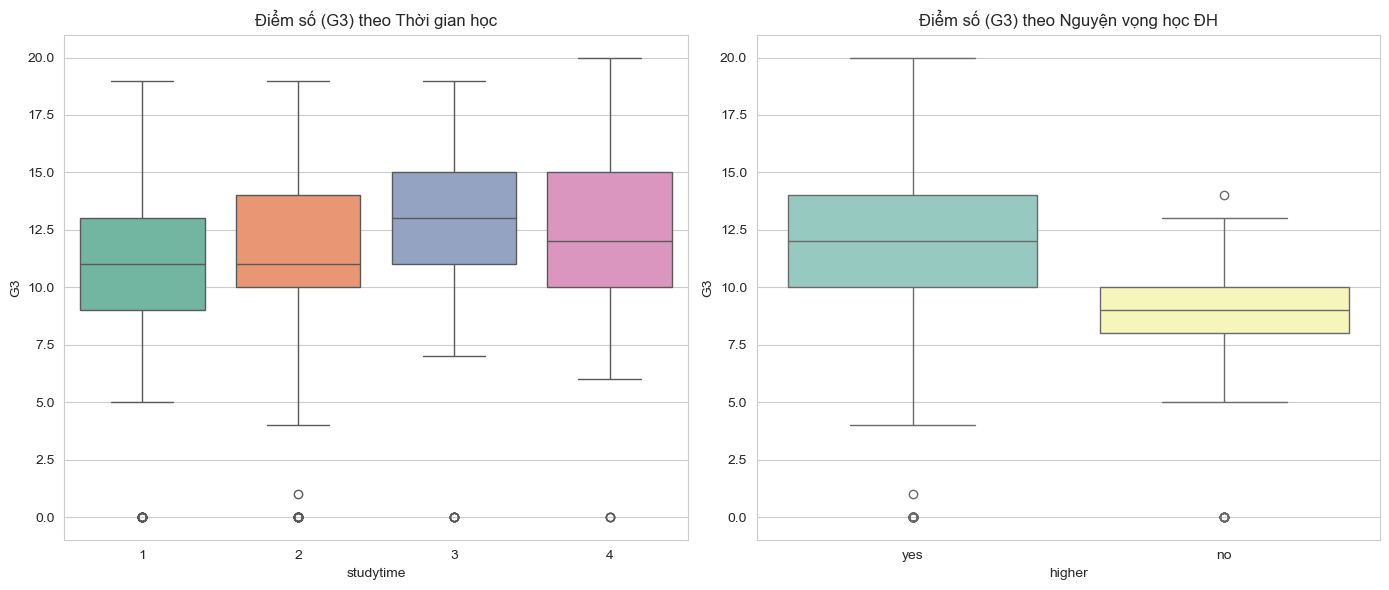


--- NHẬN XÉT SƠ BỘ ---
1. Studytime: Có xu hướng điểm trung bình tăng nhẹ khi thời gian học tăng (Mean: 10.x lên 11-12.x).
2. Higher: Nhóm muốn học lên cao ('yes') có điểm trung bình và trung vị cao hơn rõ rệt so với nhóm 'no'.
3. Jobs: Có sự tập trung lớn ở cặp nghề nghiệp (Other-Other), phản ánh đúng phân phối nghề nghiệp chung.


In [20]:
''' 
Cross-tabulations:
• For important categorical × categorical combinations, create frequency tables
• For numerical × categorical combinations, create grouped summary statistics
'''
print("--- PHÂN TÍCH BẢNG CHÉO & THỐNG KÊ NHÓM (CROSS-TABULATIONS) ---")

# ==============================================================================
# PHẦN 1: CATEGORICAL x CATEGORICAL (Tần suất giữa các nhóm)
# ==============================================================================
print("\n1. QUAN HỆ GIỮA CÁC BIẾN PHÂN LOẠI (CAT x CAT)")

# Tạo biến 'Pass' (Đậu/Rớt) để phân tích dễ hơn (G3 >= 10 là Đậu theo thang điểm Bồ Đào Nha)
df['Pass_Status'] = df['G3'].apply(lambda x: 'Pass' if x >= 10 else 'Fail')

# Ví dụ 1: Tỷ lệ Đậu/Rớt theo Giới tính
ct_sex_pass = pd.crosstab(df['sex'], df['Pass_Status'], normalize='index') * 100
print("\n- Tỷ lệ % Đậu/Rớt theo Giới tính:")
display(ct_sex_pass.round(2))

# Ví dụ 2: Nghề nghiệp của Mẹ vs Nghề nghiệp của Cha (Có xu hướng giống nhau không?)
ct_jobs = pd.crosstab(df['Mjob'], df['Fjob'])
print("\n- Bảng tần suất: Nghề nghiệp Mẹ (Hàng) vs Nghề nghiệp Cha (Cột):")
display(ct_jobs)

# Trực quan hóa Heatmap cho Job Relation
plt.figure(figsize=(10, 6))
sns.heatmap(ct_jobs, annot=True, fmt='d', cmap='Blues')
plt.title('Quan hệ nghề nghiệp giữa Cha và Mẹ')
plt.ylabel('Nghề của Mẹ')
plt.xlabel('Nghề của Cha')
plt.show()

# ==============================================================================
# PHẦN 2: NUMERICAL x CATEGORICAL (Thống kê nhóm)
# ==============================================================================
print("\n2. THỐNG KÊ BIẾN SỐ THEO NHÓM (NUM x CAT)")
print("Chúng ta sẽ xem điểm số cuối kỳ (G3) thay đổi thế nào tùy theo các nhóm khác nhau.")

# Hàm thống kê tóm tắt
def group_stats(group_col, target_col='G3'):
    return df.groupby(group_col)[target_col].agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(2)

# Nhóm 1: Điểm số theo Thời gian học thêm (studytime)
print("\n- Thống kê điểm G3 theo thời gian học (studytime):")
# studytime: 1 (<2h), 2 (2-5h), 3 (5-10h), 4 (>10h)
display(group_stats('studytime'))

# Nhóm 2: Điểm số theo Việc muốn học lên cao (higher)
print("\n- Thống kê điểm G3 theo nguyện vọng học đại học (higher):")
display(group_stats('higher'))

# Nhóm 3: Điểm số theo Nơi ở (address)
print("\n- Thống kê điểm G3 theo Nơi ở (address):")
display(group_stats('address'))

# Trực quan hóa (Boxplot so sánh)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='studytime', y='G3', data=df, palette='Set2')
plt.title('Điểm số (G3) theo Thời gian học')

plt.subplot(1, 2, 2)
sns.boxplot(x='higher', y='G3', data=df, palette='Set3')
plt.title('Điểm số (G3) theo Nguyện vọng học ĐH')

plt.tight_layout()
plt.show()

print("\n--- NHẬN XÉT SƠ BỘ ---")
print("1. Studytime: Có xu hướng điểm trung bình tăng nhẹ khi thời gian học tăng (Mean: 10.x lên 11-12.x).")
print("2. Higher: Nhóm muốn học lên cao ('yes') có điểm trung bình và trung vị cao hơn rõ rệt so với nhóm 'no'.")
print("3. Jobs: Có sự tập trung lớn ở cặp nghề nghiệp (Other-Other), phản ánh đúng phân phối nghề nghiệp chung.")

# Initial Observations & Insights

In [ ]:
''' 
Summary:
• What are 3-5 key observations from your exploration?
• What data quality issues did you identify?
• What preprocessing steps will be necessary?
• What interesting patterns emerged that could lead to research questions?
'''


In [ ]:
''' 
Red Flags:
• List any serious data quality concerns
• Note any limitations that might affect your analysis
'''